In [3]:
import os.path as op
import gc
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy import stats



In [4]:
#variables

epoch_dir = "/work/Reka_Clara/data/ds005107/derivatives/epochs"

subjects = ['01','02','03','04','05','06','07','08','09',
            '10','11','12','13','14','15','16','17','18','19',
            '20','21','22','23']

sessions = ['01','02']

runs     = ['01','02','03','04','05','06','07','08','09','10']

roi = ['MEG02','MEG29','MEG11','MEG47','MEG62','MEG15','MEG13','MEG10','MEG14',
       'MEG25','MEG48','MEG56','MEG61','MEG64','MEG52','MEG59','MEG12','MEG26',
       'MEG49', 'MEG50', 'MEG39', 'MEG54', 'MEG23', 'MEG28']



In [5]:
all_ch_sets = []

for subject in subjects:
    subj_chs = []
    for session in sessions:
        for run in runs:
            fname = op.join(
                epoch_dir,
                f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif"
            )
            if not op.exists(fname):
                continue

            ep = mne.read_epochs(fname, preload=False, verbose=False)

            # subtract bads before constructing channel set
            good_chs = set(ep.ch_names) - set(ep.info["bads"])

            subj_chs.append(good_chs)
            del ep

    if subj_chs:
        # intersection of good channels across ALL runs of that subject
        all_ch_sets.append(set.intersection(*subj_chs))


# intersection across all subjects
roi_global = set.intersection(*all_ch_sets)


roi_final = sorted(list(roi_global.intersection(roi)))

print(f"Total: {len(roi_final)} channels")

roi = roi_final

Total: 11 channels


In [6]:
def compute_alpha_tfr(ep, roi):
    freqs = np.arange(8, 13)
    tfr = mne.time_frequency.tfr_multitaper(
        ep,
        freqs=freqs,
        n_cycles=6,
        use_fft=True,
        return_itc=False,
        average=False,
        picks=roi,
        decim=2,
        n_jobs=-1,
        verbose=False,
    )
    tfr.apply_baseline((-0.2, 0), mode="percent")
    return tfr.average()

def compute_gamma_tfr(ep, roi):
    freqs = np.arange(30, 40, 2)
    tfr = mne.time_frequency.tfr_multitaper(
        ep,
        freqs=freqs,
        n_cycles=7,
        time_bandwidth=4.0,
        return_itc=False,
        average=False,
        picks=roi,
        decim=2,
        n_jobs=-1,
        verbose=False,
    )
    tfr.apply_baseline((-0.2, 0), mode="percent")
    tfr.crop(tmin=-0.15, tmax=0.6)
    return tfr.average()

In [8]:


roi = roi_final
alpha_tfr_emotion = []
alpha_tfr_neutral = []
gamma_tfr_emotion = []
gamma_tfr_neutral = []
alpha_contrasts = []
gamma_contrasts = []

for subject in subjects:
    eps = []
    for session in sessions:
        for run in runs:
            fname = op.join(
                epoch_dir,
                f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif",
            )
            if not op.exists(fname):
                continue
            ep = mne.read_epochs(fname, preload=True, verbose=False)
            if ep.metadata is None or "emotion" not in ep.metadata.columns:
                continue
            ep.pick_channels(roi, ordered=True)
            eps.append(ep)
    if not eps:
        print(f"Subject {subject}: No valid epochs found")
        continue
    epochs = mne.concatenate_epochs(eps)
    md = epochs.metadata
    e_mask = md["emotion"] == 2
    n_mask = md["emotion"] == 1
    n_emotion = e_mask.sum()
    n_neutral = n_mask.sum()
    if n_emotion < 10 or n_neutral < 10:
        print(f"Subject {subject}: Too few trials (E={n_emotion}, N={n_neutral}), skipping")
        continue
    print(f"Subject {subject}: Emotion={n_emotion}, Neutral={n_neutral}")
    
    ep_e = epochs[e_mask]
    
    ep_n = epochs[n_mask]
    
    tfr_e_alpha = compute_alpha_tfr(ep_e, roi)
    
    tfr_n_alpha = compute_alpha_tfr(ep_n, roi)
    
    alpha_tfr_emotion.append(tfr_e_alpha)
    
    alpha_tfr_neutral.append(tfr_n_alpha)
    
    tfr_contrast_alpha = tfr_e_alpha.copy()
    tfr_contrast_alpha.data = tfr_e_alpha.data - tfr_n_alpha.data
    
    alpha_contrasts.append(tfr_contrast_alpha)
    
    tfr_e_gamma = compute_gamma_tfr(ep_e, roi)
    tfr_n_gamma = compute_gamma_tfr(ep_n, roi)
    gamma_tfr_emotion.append(tfr_e_gamma)
    gamma_tfr_neutral.append(tfr_n_gamma)
    tfr_contrast_gamma = tfr_e_gamma.copy()
    tfr_contrast_gamma.data = tfr_e_gamma.data - tfr_n_gamma.data
    gamma_contrasts.append(tfr_contrast_gamma)
    gc.collect()

print("\n=== Analysis complete ===")
print(f"Number of subjects with valid data: {len(alpha_contrasts)}")

tfr_diff_alpha = mne.grand_average(alpha_contrasts)
tfr_diff_gamma = mne.grand_average(gamma_contrasts)

alpha_data_all = np.array([tfr.data for tfr in alpha_contrasts])
alpha_sem = stats.sem(alpha_data_all, axis=0)

gamma_data_all = np.array([tfr.data for tfr in gamma_contrasts])
gamma_sem = stats.sem(gamma_data_all, axis=0)



NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Adding metadata with 5 columns
5030 matching events found
Applying baseline correction (mode: mean)
Subject 01: Emotion=2520, Neutral=2510
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functio

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels(

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 03: Emotion=2514, Neutral=2520
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 04: Emotion=2525, Neutral=2516
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Subject 05: No valid epochs found
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a 

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 06: Emotion=2501, Neutral=2507
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 07: Emotion=2473, Neutral=2460
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 08: Emotion=1256, Neutral=1267
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 09: Emotion=2523, Neutral=2531
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 10: Emotion=991, Neutral=1001
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should us

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 11: Emotion=1740, Neutral=1737
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
Subject 12: No valid epochs found
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a 

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 13: Emotion=2510, Neutral=2512
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 14: Emotion=2496, Neutral=2507
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 15: Emotion=1267, Neutral=1260
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 16: Emotion=1248, Neutral=1252
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 17: Emotion=2504, Neutral=2514
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 18: Emotion=1255, Neutral=1263
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 19: Emotion=2515, Neutral=2512
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 20: Emotion=2502, Neutral=2496
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 21: Emotion=2516, Neutral=2519
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 22: Emotion=1244, Neutral=1252
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should u

/tmp/ipykernel_1072/1143577654.py:27: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(eps)


Subject 23: Emotion=2505, Neutral=2501
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
Applying baseline correction (mode: percent)

=== Analysis complete ===
Number of subjects with valid data: 21
Identifying common channels ...
Identifying common channels ...


In [25]:
print("\n=== Diagnostic Information ===")
print(f"Number of subjects: {len(alpha_contrasts)}")

print("\nALPHA:")
print(f"  Frequency range: {tfr_diff_alpha.freqs.min():.1f} - {tfr_diff_alpha.freqs.max():.1f} Hz")
print(f"  Time range: {tfr_diff_alpha.times.min():.2f} - {tfr_diff_alpha.times.max():.2f} s")
print(f"  Power range: {alpha_power.min():.2f}% to {alpha_power.max():.2f}%")
print(f"  Baseline mean: {alpha_power[tfr_diff_alpha.times < 0].mean():.3f}%")
print(f"  Max ERD at: {tfr_diff_alpha.times[np.argmin(alpha_power)]:.3f}s")

print("\nGAMMA:")
print(f"  Frequency range: {tfr_diff_gamma.freqs.min():.1f} - {tfr_diff_gamma.freqs.max():.1f} Hz")
print(f"  Time range: {tfr_diff_gamma.times.min():.2f} - {tfr_diff_gamma.times.max():.2f} s")
print(f"  Power range: {gamma_power.min():.2f}% to {gamma_power.max():.2f}%")
print(f"  Baseline mean: {gamma_power[tfr_diff_gamma.times < 0].mean():.3f}%")

print("\n=== Statistical Overview ===")
alpha_tvals = []
for t_idx in range(alpha_data_all.shape[-1]):
    t_stat_tmp, p_val_tmp = stats.ttest_1samp(
        alpha_data_all[:, :, fmask_alpha, t_idx].mean(axis=(1, 2)),
        0,
    )
    alpha_tvals.append(t_stat_tmp)

sig_points = np.abs(alpha_tvals) > 2.0
if sig_points.any():
    print(f"Alpha: {sig_points.sum()} time points show |t| > 2.0")
else:
    print("Alpha: No strong effects detected")

time_window = (tfr_diff_alpha.times >= 0.15) & (tfr_diff_alpha.times <= 0.35)

subject_emotion = []
subject_neutral = []

for tfr_e, tfr_n in zip(alpha_tfr_emotion, alpha_tfr_neutral):
    e_val = tfr_e.data[:, fmask_alpha, :][:, :, time_window].mean()
    n_val = tfr_n.data[:, fmask_alpha, :][:, :, time_window].mean()
    subject_emotion.append(e_val)
    subject_neutral.append(n_val)

subject_emotion = np.array(subject_emotion)
subject_neutral = np.array(subject_neutral)
subject_effects = subject_emotion - subject_neutral

mean_effect = subject_effects.mean()
std_effect = subject_effects.std()
cohens_d = mean_effect / std_effect if std_effect > 0 else 0.0

t_stat, p_val = stats.ttest_rel(subject_emotion, subject_neutral)

print("Alpha contrast (Emotion - Neutral) in 150–350 ms window:")
print(f"  Mean effect: {mean_effect:.4f}%")
print(f"  Std dev: {std_effect:.4f}%")
print(f"  Cohen's d: {cohens_d:.3f}")
print(f"  t({len(subject_effects) - 1}) = {t_stat:.3f}, p = {p_val:.4f}")
print()

if abs(cohens_d) < 0.2:
    effect_interpretation = "NEGLIGIBLE (|d| < 0.2)"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "SMALL (0.2 ≤ |d| < 0.5)"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "MEDIUM (0.5 ≤ |d| < 0.8)"
else:
    effect_interpretation = "LARGE (|d| ≥ 0.8)"

print(f"Effect size interpretation: {effect_interpretation}")

n = len(subject_effects)
if p_val > 0.05:
    print(f"\nResult: NOT SIGNIFICANT (p = {p_val:.4f})")
    print(f"With n={n} subjects and observed effect size d={cohens_d:.3f}:")
    if cohens_d != 0:
        z_alpha = 1.96
        z_beta = 0.84
        n_needed = ((z_alpha + z_beta) / cohens_d) ** 2
        print(f"  You would need approximately {int(np.ceil(n_needed))} subjects")
        print("  for 80% power to detect this effect size.")
else:
    print(f"\nResult: SIGNIFICANT (p = {p_val:.4f})")
    print("The emotional modulation is statistically reliable.")



=== Diagnostic Information ===
Number of subjects: 21

ALPHA:
  Frequency range: 8.0 - 12.0 Hz
  Time range: -0.20 - 0.80 s
  Power range: -0.02% to 0.00%
  Baseline mean: -0.000%
  Max ERD at: 0.662s

GAMMA:
  Frequency range: 30.0 - 38.0 Hz
  Time range: -0.15 - 0.60 s
  Power range: -0.01% to 0.00%
  Baseline mean: 0.000%

=== Statistical Overview ===
Alpha: 140 time points show |t| > 2.0
Alpha contrast (Emotion - Neutral) in 150–350 ms window:
  Mean effect: -0.0049%
  Std dev: 0.0238%
  Cohen's d: -0.206
  t(20) = -0.923, p = 0.3672

Effect size interpretation: SMALL (0.2 ≤ |d| < 0.5)

Result: NOT SIGNIFICANT (p = 0.3672)
With n=21 subjects and observed effect size d=-0.206:
  You would need approximately 185 subjects
  for 80% power to detect this effect size.


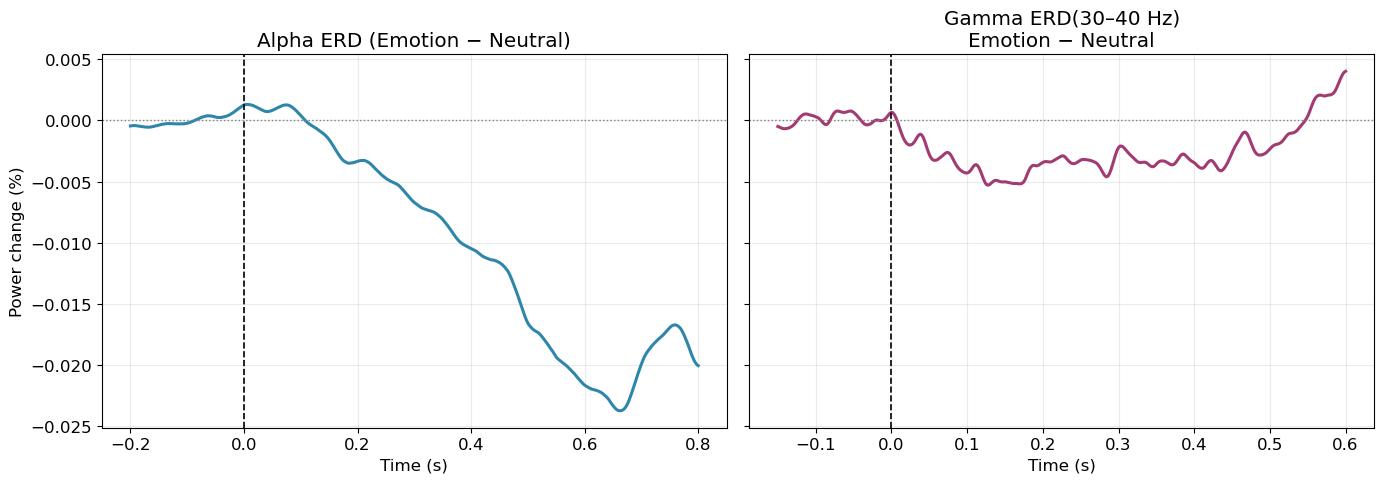

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

ax = axes[0]
ax.plot(tfr_diff_alpha.times, alpha_power, linewidth=2.2, color="#2E86AB")
ax.axvline(0, color="black", linestyle="--", linewidth=1.2)
ax.axhline(0, color="gray", linestyle=":", linewidth=1)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Power change (%)")
ax.set_title("Alpha ERD (Emotion − Neutral)")
ax.grid(alpha=0.25)

fmask_gamma = (tfr_diff_gamma.freqs >= 30) & (tfr_diff_gamma.freqs <= 40)
gamma_power = tfr_diff_gamma.data[:, fmask_gamma, :].mean(axis=(0, 1))

ax = axes[1]
ax.plot(tfr_diff_gamma.times, gamma_power, linewidth=2.2, color="#A23B72")
ax.axvline(0, color="black", linestyle="--", linewidth=1.2)
ax.axhline(0, color="gray", linestyle=":", linewidth=1)

ax.set_xlabel("Time (s)")
ax.set_title("Gamma ERD (30–40 Hz)\nEmotion − Neutral")
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()


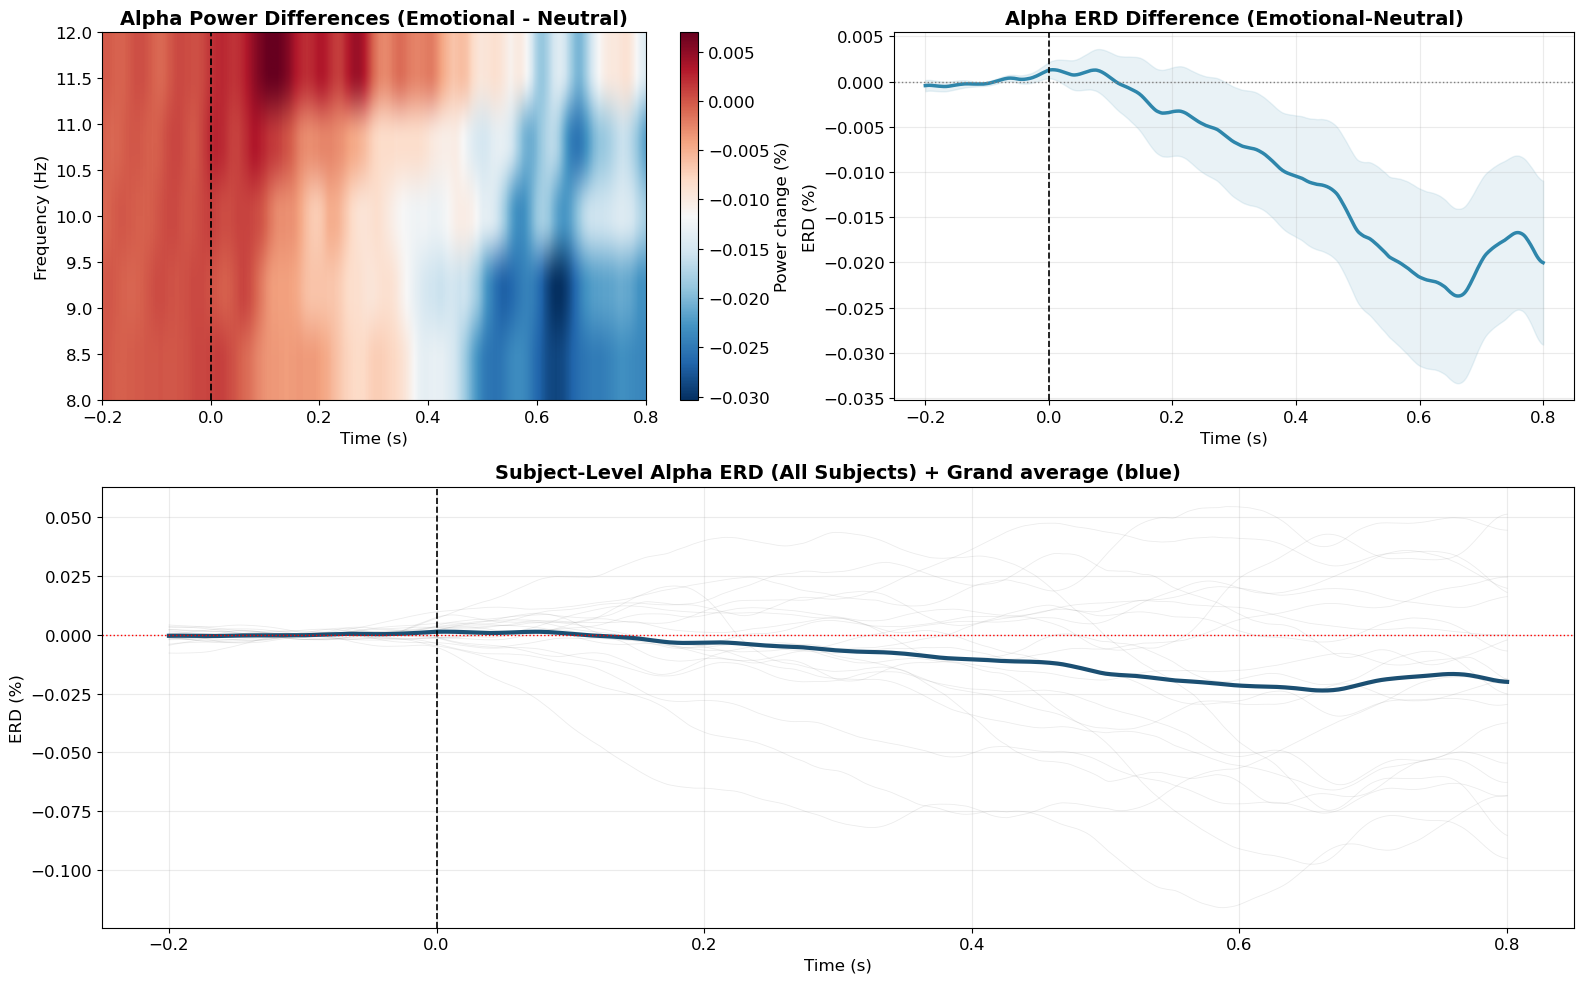

In [73]:
fmask_alpha = (tfr_diff_alpha.freqs >= 8) & (tfr_diff_alpha.freqs <= 12)
alpha_power = tfr_diff_alpha.data[:, fmask_alpha, :].mean(axis=(0, 1))
alpha_sem_time = stats.sem(
    alpha_data_all[:, :, fmask_alpha, :].mean(axis=(1, 2)),
    axis=0
)

plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

# === Panel 1: Alpha TFR Heatmap ===
ax5 = fig.add_subplot(gs[0, 0])
im = ax5.imshow(
    tfr_diff_alpha.data.mean(axis=0),
    aspect="auto",
    origin="lower",
    extent=[tfr_diff_alpha.times[0], tfr_diff_alpha.times[-1],
            tfr_diff_alpha.freqs[0], tfr_diff_alpha.freqs[-1]],
    cmap="RdBu_r"
)

ax5.axvline(0, color="black", linestyle="--", linewidth=1.3)
ax5.set_title("Alpha Power Differences (Emotional - Neutral)", fontsize=14, fontweight="bold")
ax5.set_xlabel("Time (s)")
ax5.set_ylabel("Frequency (Hz)")
plt.colorbar(im, ax=ax5, label="Power change (%)")

plt.tight_layout()



# === TOP RIGHT ===
ax_grand = fig.add_subplot(gs[0, 1])
ax_grand.plot(tfr_diff_alpha.times, alpha_power, linewidth=2.5, color="#2E86AB")
ax_grand.fill_between(
    tfr_diff_alpha.times,
    alpha_power - alpha_sem_time,
    alpha_power + alpha_sem_time,
    alpha=0.1,
    color="#2E86AB"
)
ax_grand.axvline(0, color="black", linestyle="--", linewidth=1.2)
ax_grand.axhline(0, color="gray", linestyle=":", linewidth=1)
ax_grand.set_title("Alpha ERD Difference (Emotional-Neutral)", fontsize=14, fontweight="bold")
ax_grand.set_xlabel("Time (s)")
ax_grand.set_ylabel("ERD (%)")
ax_grand.grid(alpha=0.25)

# === BOTTOM (FULL WIDTH) ===
ax_subj = fig.add_subplot(gs[1, :])     # <-- spans BOTH COLUMNS
for tfr in alpha_contrasts:
    trace = tfr.data[:, fmask_alpha, :].mean(axis=(0, 1))
    ax_subj.plot(tfr.times, trace, alpha=0.15, color="gray", linewidth=0.6)

ax_subj.plot(tfr_diff_alpha.times, alpha_power, linewidth=3, color="#1B4F72")
ax_subj.axvline(0, color="black", linestyle="--", linewidth=1.2)
ax_subj.axhline(0, color="red", linestyle=":", linewidth=1)
ax_subj.set_title("Subject-Level Alpha ERD (All Subjects) + Grand average (blue)", fontsize=14, fontweight="bold")
ax_subj.set_xlabel("Time (s)")
ax_subj.set_ylabel("ERD (%)")
ax_subj.grid(alpha=0.25)



plt.tight_layout()
plt.savefig("alpha_erd.png", dpi = 150)
plt.show()



In [57]:
from mne.stats import permutation_cluster_test

# alpha_tfr_emotion: list of TFR objects (subjects)
# alpha_tfr_neutral: list of TFR objects (subjects)

# restrict to alpha band
fmask = (tfr_diff_alpha.freqs >= 8) & (tfr_diff_alpha.freqs <= 12)

# extract subject × time arrays
E = []
N = []
for tfr_e, tfr_n in zip(alpha_tfr_emotion, alpha_tfr_neutral):
    e = tfr_e.data[:, fmask, :].mean(axis=(0,1))
    n = tfr_n.data[:, fmask, :].mean(axis=(0,1))
    E.append(e)
    N.append(n)

E = np.array(E)   # shape (n_subj, time)
N = np.array(N)


tmin, tmax = 0, 0.8
tw = (tfr_diff_alpha.times >= tmin) & (tfr_diff_alpha.times <= tmax)

Ew = E[:, :]
Nw = N[:, :]

X = [Ew, Nw]

T_obs, clusters, pvals, _ = permutation_cluster_test(
    X,
    n_permutations=5000,
    tail=1,
    out_type='mask'
)

print("Cluster p-values:", pvals)


Using a threshold of 4.084746
stat_fun(H1): min=4.435551231595687e-08 max=0.05387415253079946
Running initial clustering …
Found 0 clusters
Cluster p-values: []


/tmp/ipykernel_1072/3504913856.py:31: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, pvals, _ = permutation_cluster_test(
